In [1]:
# import some libraries
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# load the dataset
num_classes = 10 
cifar10 = tf.keras.datasets.cifar10
(x_learn, y_learn),(x_test, y_test) = cifar10.load_data()

# Normalize the data in [0 1]
print("Normalizing training set..")
x_learn = np.asarray(x_learn, dtype=np.float32) / 255 # Normalizing training set
print("Normalizing test set..")
x_test = np.asarray(x_test, dtype=np.float32) / 255 # Normalizing test set

Normalizing training set..
Normalizing test set..


In [3]:
# split in training and validation
x_train, x_val, y_train, y_val = train_test_split(x_learn, y_learn, test_size=0.25, random_state=12)

In [4]:

# Standardizing the data
def standardize_dataset(X):
    image_means = []
    image_stds = []

    for image in X:
        image_means.append(np.mean(image)) # Computing the image mean
        image_stds.append(np.std(image)) # Computing the image standard deviation

    dataset_mean = np.mean(image_means) # Computing the dataset mean
    dataset_std = np.mean(image_stds) # Computing the dataset standard deviation
    return [dataset_mean, dataset_std] # For every image we subtract to it the dataset mean and we divide by the dataset standard deviation

dataset_mean, dataset_std = standardize_dataset(x_train)

print("Standardizing training set..")
x_train = (x_train-dataset_mean)/dataset_std # Standardizing the training set
print("Standardizing validation set..")
x_val = (x_val-dataset_mean)/dataset_std # Standardizing the test set
print("Standardizing test set..")
x_test = (x_test-dataset_mean)/dataset_std # Standardizing the test set

# one hot encode target values
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)


print("Size of the training set")
print("x_train", x_train.shape)
print("y_train", y_train.shape)

print("Size of the validation set")
print("x_val", x_val.shape)
print("y_val", y_val.shape)

print("Size of the test set")
print("x_test", x_test.shape)
print("y_test", y_test.shape)

Standardizing training set..
Standardizing validation set..
Standardizing test set..
Size of the training set
x_train (37500, 32, 32, 3)
y_train (37500, 10)
Size of the validation set
x_val (12500, 32, 32, 3)
y_val (12500, 10)
Size of the test set
x_test (10000, 32, 32, 3)
y_test (10000, 10)


#### Plot some sample from the training set

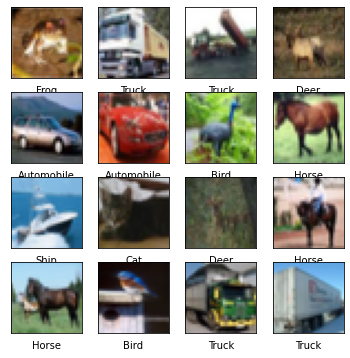

In [5]:

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_learn[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_learn[i,0]])
plt.show()

## Build a Model



In [6]:
from tensorflow import keras 
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras import layers,regularizers
from keras.layers import Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization

tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


num_filters_1=32
num_filters_2=64
num_filters_3=128
filter_size=3
pool_size=2

l2_norm = .0001
model = Sequential()
model.add(Conv2D(num_filters_1,filter_size, padding='same', 
                kernel_regularizer=regularizers.l2(l2_norm), input_shape=x_train.shape[1:],activation='elu'))
model.add(BatchNormalization())

model.add(Conv2D(num_filters_1, filter_size, padding='same', 
                kernel_regularizer=regularizers.l2(l2_norm),activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2)) 
model.add(Conv2D(num_filters_2, filter_size, padding='same', 
                kernel_regularizer=regularizers.l2(l2_norm),activation='elu'))
model.add(BatchNormalization())

model.add(Conv2D(num_filters_2, filter_size, padding='same', 
                kernel_regularizer=regularizers.l2(l2_norm),activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))
model.add(Conv2D(num_filters_3, filter_size, padding='same', 
                kernel_regularizer=regularizers.l2(l2_norm),activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_filters_3, filter_size, padding='same', 
                kernel_regularizer=regularizers.l2(l2_norm),activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [7]:
from keras.optimizers import Adam, SGD, Adadelta, Adagrad, Adamax, Nadam, RMSprop

adamax = Adamax(lr=0.002,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0)
nadam = Nadam(lr=0.002,beta_1=0.9,beta_2=0.999,epsilon=None,schedule_decay=0.004)
# Losses    https://keras.io/losses/
loss = ['categorical_crossentropy']

# Metrics    https://www.tensorflow.org/api_docs/python/tf/metrics
metrics = ['accuracy','precision','recall']

# Compile the model you created before using 
# rms optimizer as optimizer
# categorical crossentropy as loss function
# accuracy as metric
    
model.compile(optimizer=nadam,
              loss=loss[0],
              metrics=[metrics[0]],
              )

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [8]:
batch_size = 64
epochs = 200
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

es_callback = EarlyStopping(monitor='val_accuracy', patience=20,verbose=1)

checkpoint_path = "output/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(checkpoint_path,monitor='val_accuracy',save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
#lr_scheduler=keras.callbacks.LearningRateScheduler(lr_schedule)
history = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
		validation_data=(x_val, y_val), epochs=epochs,
        callbacks= [lr_scheduler,es_callback,cp_callback], verbose=1)

Epoch 1/200
586/586 [==============================] - ETA: 0s - loss: 2.2327 - accuracy: 0.3220

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 128s 213ms/step - loss: 2.2327 - accuracy: 0.3220 - val_loss: 1.8386 - val_accuracy: 0.4187 - lr: 0.0020
Epoch 2/200
586/586 [==============================] - ETA: 0s - loss: 1.6936 - accuracy: 0.4358

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 115s 196ms/step - loss: 1.6936 - accuracy: 0.4358 - val_loss: 1.7825 - val_accuracy: 0.4570 - lr: 0.0020
Epoch 3/200
586/586 [==============================] - ETA: 0s - loss: 1.4586 - accuracy: 0.5098

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 131s 224ms/step - loss: 1.4586 - accuracy: 0.5098 - val_loss: 1.4827 - val_accuracy: 0.5202 - lr: 0.0020
Epoch 4/200
586/586 [==============================] - ETA: 0s - loss: 1.3420 - accuracy: 0.5475

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 142s 243ms/step - loss: 1.3420 - accuracy: 0.5475 - val_loss: 1.3613 - val_accuracy: 0.5656 - lr: 0.0020
Epoch 5/200
586/586 [==============================] - ETA: 0s - loss: 1.2772 - accuracy: 0.5785

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 151s 258ms/step - loss: 1.2772 - accuracy: 0.5785 - val_loss: 1.2616 - val_accuracy: 0.5994 - lr: 0.0020
Epoch 6/200
586/586 [==============================] - ETA: 0s - loss: 1.2421 - accuracy: 0.5969

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 151s 258ms/step - loss: 1.2421 - accuracy: 0.5969 - val_loss: 1.2724 - val_accuracy: 0.6067 - lr: 0.0020
Epoch 7/200
586/586 [==============================] - ETA: 0s - loss: 1.2134 - accuracy: 0.6136

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 150s 255ms/step - loss: 1.2134 - accuracy: 0.6136 - val_loss: 1.1622 - val_accuracy: 0.6487 - lr: 0.0020
Epoch 8/200
586/586 [==============================] - ETA: 0s - loss: 1.2018 - accuracy: 0.6224

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 151s 257ms/step - loss: 1.2018 - accuracy: 0.6224 - val_loss: 1.1298 - val_accuracy: 0.6610 - lr: 0.0020
Epoch 9/200
586/586 [==============================] - 148s 253ms/step - loss: 1.1867 - accuracy: 0.6358 - val_loss: 1.2625 - val_accuracy: 0.6415 - lr: 0.0020
Epoch 10/200
586/586 [==============================] - 148s 253ms/step - loss: 1.1749 - accuracy: 0.6442 - val_loss: 1.1777 - val_accuracy: 0.6558 - lr: 0.0020
Epoch 11/200
586/586 [==============================] - ETA: 0s - loss: 1.1687 - accuracy: 0.6493

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 162s 276ms/step - loss: 1.1687 - accuracy: 0.6493 - val_loss: 1.1417 - val_accuracy: 0.6721 - lr: 0.0020
Epoch 12/200
586/586 [==============================] - ETA: 0s - loss: 1.1627 - accuracy: 0.6563

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 183s 313ms/step - loss: 1.1627 - accuracy: 0.6563 - val_loss: 1.1529 - val_accuracy: 0.6782 - lr: 0.0020
Epoch 13/200
586/586 [==============================] - 196s 335ms/step - loss: 1.1538 - accuracy: 0.6589 - val_loss: 1.1675 - val_accuracy: 0.6690 - lr: 0.0020
Epoch 14/200
586/586 [==============================] - ETA: 0s - loss: 1.0779 - accuracy: 0.6884

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 206s 351ms/step - loss: 1.0779 - accuracy: 0.6884 - val_loss: 1.0587 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 15/200
586/586 [==============================] - 178s 304ms/step - loss: 1.0466 - accuracy: 0.6975 - val_loss: 1.1062 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 16/200
586/586 [==============================] - ETA: 0s - loss: 1.0304 - accuracy: 0.7002

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 207s 352ms/step - loss: 1.0304 - accuracy: 0.7002 - val_loss: 1.0433 - val_accuracy: 0.7034 - lr: 0.0010
Epoch 17/200
586/586 [==============================] - ETA: 0s - loss: 1.0196 - accuracy: 0.7044

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 206s 352ms/step - loss: 1.0196 - accuracy: 0.7044 - val_loss: 0.9483 - val_accuracy: 0.7341 - lr: 0.0010
Epoch 18/200
586/586 [==============================] - 203s 346ms/step - loss: 1.0120 - accuracy: 0.7059 - val_loss: 1.0469 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 19/200
586/586 [==============================] - 201s 343ms/step - loss: 1.0011 - accuracy: 0.7055 - val_loss: 0.9374 - val_accuracy: 0.7315 - lr: 0.0010
Epoch 20/200
586/586 [==============================] - ETA: 0s - loss: 0.9878 - accuracy: 0.7115

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 206s 352ms/step - loss: 0.9878 - accuracy: 0.7115 - val_loss: 0.9266 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 21/200
586/586 [==============================] - 199s 340ms/step - loss: 0.9795 - accuracy: 0.7123 - val_loss: 0.9615 - val_accuracy: 0.7339 - lr: 0.0010
Epoch 22/200
586/586 [==============================] - 203s 347ms/step - loss: 0.9732 - accuracy: 0.7155 - val_loss: 1.0567 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 23/200
586/586 [==============================] - 199s 339ms/step - loss: 0.9687 - accuracy: 0.7163 - val_loss: 0.9342 - val_accuracy: 0.7369 - lr: 0.0010
Epoch 24/200
586/586 [==============================] - 196s 334ms/step - loss: 0.9635 - accuracy: 0.7186 - val_loss: 1.0331 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 25/200
586/586 [==============================] - ETA: 0s - loss: 0.9595 - accuracy: 0.7183

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 205s 349ms/step - loss: 0.9595 - accuracy: 0.7183 - val_loss: 0.8998 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 26/200
586/586 [==============================] - 200s 341ms/step - loss: 0.9528 - accuracy: 0.7195 - val_loss: 0.9898 - val_accuracy: 0.7234 - lr: 0.0010
Epoch 27/200
586/586 [==============================] - 200s 341ms/step - loss: 0.9531 - accuracy: 0.7254 - val_loss: 0.9352 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 28/200
586/586 [==============================] - 204s 348ms/step - loss: 0.9458 - accuracy: 0.7265 - val_loss: 0.9561 - val_accuracy: 0.7316 - lr: 0.0010
Epoch 29/200
586/586 [==============================] - 203s 345ms/step - loss: 0.9477 - accuracy: 0.7255 - val_loss: 0.9494 - val_accuracy: 0.7364 - lr: 0.0010
Epoch 30/200
586/586 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.7298

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 213s 363ms/step - loss: 0.9414 - accuracy: 0.7298 - val_loss: 0.9039 - val_accuracy: 0.7501 - lr: 0.0010
Epoch 31/200
586/586 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.7430

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 191s 326ms/step - loss: 0.8932 - accuracy: 0.7430 - val_loss: 0.8790 - val_accuracy: 0.7598 - lr: 5.0000e-04
Epoch 32/200
586/586 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.7474

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 194s 331ms/step - loss: 0.8798 - accuracy: 0.7474 - val_loss: 0.8412 - val_accuracy: 0.7690 - lr: 5.0000e-04
Epoch 33/200
586/586 [==============================] - 174s 297ms/step - loss: 0.8709 - accuracy: 0.7496 - val_loss: 0.8819 - val_accuracy: 0.7551 - lr: 5.0000e-04
Epoch 34/200
586/586 [==============================] - 169s 289ms/step - loss: 0.8598 - accuracy: 0.7522 - val_loss: 0.8792 - val_accuracy: 0.7572 - lr: 5.0000e-04
Epoch 35/200
586/586 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.7533

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 175s 298ms/step - loss: 0.8547 - accuracy: 0.7533 - val_loss: 0.8163 - val_accuracy: 0.7763 - lr: 5.0000e-04
Epoch 36/200
586/586 [==============================] - 165s 281ms/step - loss: 0.8477 - accuracy: 0.7566 - val_loss: 0.8096 - val_accuracy: 0.7755 - lr: 5.0000e-04
Epoch 37/200
586/586 [==============================] - 173s 296ms/step - loss: 0.8378 - accuracy: 0.7557 - val_loss: 0.8682 - val_accuracy: 0.7641 - lr: 5.0000e-04
Epoch 38/200
586/586 [==============================] - 176s 300ms/step - loss: 0.8417 - accuracy: 0.7558 - val_loss: 0.8250 - val_accuracy: 0.7714 - lr: 5.0000e-04
Epoch 39/200
586/586 [==============================] - 167s 285ms/step - loss: 0.8361 - accuracy: 0.7574 - val_loss: 0.8248 - val_accuracy: 0.7709 - lr: 5.0000e-04
Epoch 40/200
586/586 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.7593

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 164s 280ms/step - loss: 0.8311 - accuracy: 0.7593 - val_loss: 0.8021 - val_accuracy: 0.7786 - lr: 5.0000e-04
Epoch 41/200
586/586 [==============================] - 156s 267ms/step - loss: 0.8237 - accuracy: 0.7616 - val_loss: 0.8571 - val_accuracy: 0.7627 - lr: 5.0000e-04
Epoch 42/200
586/586 [==============================] - ETA: 0s - loss: 0.8254 - accuracy: 0.7583

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 159s 271ms/step - loss: 0.8254 - accuracy: 0.7583 - val_loss: 0.7881 - val_accuracy: 0.7801 - lr: 5.0000e-04
Epoch 43/200
586/586 [==============================] - 158s 270ms/step - loss: 0.8142 - accuracy: 0.7631 - val_loss: 0.8261 - val_accuracy: 0.7733 - lr: 5.0000e-04
Epoch 44/200
586/586 [==============================] - 158s 270ms/step - loss: 0.8132 - accuracy: 0.7627 - val_loss: 0.8205 - val_accuracy: 0.7701 - lr: 5.0000e-04
Epoch 45/200
586/586 [==============================] - 158s 270ms/step - loss: 0.8031 - accuracy: 0.7661 - val_loss: 0.8278 - val_accuracy: 0.7685 - lr: 5.0000e-04
Epoch 46/200
586/586 [==============================] - 158s 269ms/step - loss: 0.8079 - accuracy: 0.7652 - val_loss: 0.7984 - val_accuracy: 0.7786 - lr: 5.0000e-04
Epoch 47/200
586/586 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.7655

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 160s 273ms/step - loss: 0.8053 - accuracy: 0.7655 - val_loss: 0.7630 - val_accuracy: 0.7882 - lr: 5.0000e-04
Epoch 48/200
586/586 [==============================] - 158s 269ms/step - loss: 0.8071 - accuracy: 0.7636 - val_loss: 0.8332 - val_accuracy: 0.7688 - lr: 5.0000e-04
Epoch 49/200
586/586 [==============================] - 159s 272ms/step - loss: 0.8031 - accuracy: 0.7659 - val_loss: 0.7871 - val_accuracy: 0.7780 - lr: 5.0000e-04
Epoch 50/200
586/586 [==============================] - 159s 271ms/step - loss: 0.8021 - accuracy: 0.7652 - val_loss: 0.7876 - val_accuracy: 0.7816 - lr: 5.0000e-04
Epoch 51/200
586/586 [==============================] - 159s 271ms/step - loss: 0.7965 - accuracy: 0.7691 - val_loss: 0.8169 - val_accuracy: 0.7708 - lr: 5.0000e-04
Epoch 52/200
586/586 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.7649

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 160s 273ms/step - loss: 0.8054 - accuracy: 0.7649 - val_loss: 0.7456 - val_accuracy: 0.7936 - lr: 5.0000e-04
Epoch 53/200
586/586 [==============================] - 157s 267ms/step - loss: 0.7936 - accuracy: 0.7690 - val_loss: 0.7731 - val_accuracy: 0.7818 - lr: 5.0000e-04
Epoch 54/200
586/586 [==============================] - ETA: 0s - loss: 0.7899 - accuracy: 0.7703

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 159s 272ms/step - loss: 0.7899 - accuracy: 0.7703 - val_loss: 0.7415 - val_accuracy: 0.7946 - lr: 5.0000e-04
Epoch 55/200
586/586 [==============================] - 157s 269ms/step - loss: 0.7866 - accuracy: 0.7692 - val_loss: 0.7836 - val_accuracy: 0.7823 - lr: 5.0000e-04
Epoch 56/200
586/586 [==============================] - 161s 274ms/step - loss: 0.7903 - accuracy: 0.7691 - val_loss: 0.7866 - val_accuracy: 0.7822 - lr: 5.0000e-04
Epoch 57/200
586/586 [==============================] - 158s 270ms/step - loss: 0.7826 - accuracy: 0.7734 - val_loss: 0.7873 - val_accuracy: 0.7818 - lr: 5.0000e-04
Epoch 58/200
586/586 [==============================] - 161s 275ms/step - loss: 0.7823 - accuracy: 0.7714 - val_loss: 0.8132 - val_accuracy: 0.7721 - lr: 5.0000e-04
Epoch 59/200
586/586 [==============================] - 159s 272ms/step - loss: 0.7827 - accuracy: 0.7726 - val_loss: 0.7784 - val_accuracy: 0.7845 - lr: 5.0000e-04
Epoch 60/200
586/586 [=

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 163s 278ms/step - loss: 0.7445 - accuracy: 0.7833 - val_loss: 0.7263 - val_accuracy: 0.7990 - lr: 2.5000e-04
Epoch 63/200
586/586 [==============================] - 161s 275ms/step - loss: 0.7338 - accuracy: 0.7857 - val_loss: 0.7458 - val_accuracy: 0.7959 - lr: 2.5000e-04
Epoch 64/200
586/586 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.7860

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 163s 278ms/step - loss: 0.7351 - accuracy: 0.7860 - val_loss: 0.6788 - val_accuracy: 0.8084 - lr: 2.5000e-04
Epoch 65/200
586/586 [==============================] - 157s 269ms/step - loss: 0.7249 - accuracy: 0.7907 - val_loss: 0.7615 - val_accuracy: 0.7910 - lr: 2.5000e-04
Epoch 66/200
586/586 [==============================] - 160s 273ms/step - loss: 0.7279 - accuracy: 0.7871 - val_loss: 0.7300 - val_accuracy: 0.7952 - lr: 2.5000e-04
Epoch 67/200
586/586 [==============================] - 163s 278ms/step - loss: 0.7253 - accuracy: 0.7882 - val_loss: 0.7216 - val_accuracy: 0.8016 - lr: 2.5000e-04
Epoch 68/200
586/586 [==============================] - 161s 275ms/step - loss: 0.7250 - accuracy: 0.7858 - val_loss: 0.7098 - val_accuracy: 0.8054 - lr: 2.5000e-04
Epoch 69/200
586/586 [==============================] - 163s 279ms/step - loss: 0.7211 - accuracy: 0.7884 - val_loss: 0.7088 - val_accuracy: 0.8047 - lr: 2.5000e-04
Epoch 70/200
586/586 [=

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 167s 284ms/step - loss: 0.7065 - accuracy: 0.7919 - val_loss: 0.6943 - val_accuracy: 0.8100 - lr: 1.2500e-04
Epoch 71/200
586/586 [==============================] - 159s 271ms/step - loss: 0.7002 - accuracy: 0.7961 - val_loss: 0.7093 - val_accuracy: 0.8064 - lr: 1.2500e-04
Epoch 72/200
586/586 [==============================] - 159s 271ms/step - loss: 0.6996 - accuracy: 0.7974 - val_loss: 0.6937 - val_accuracy: 0.8094 - lr: 1.2500e-04
Epoch 73/200
586/586 [==============================] - 158s 270ms/step - loss: 0.6992 - accuracy: 0.7946 - val_loss: 0.7041 - val_accuracy: 0.8051 - lr: 1.2500e-04
Epoch 74/200
586/586 [==============================] - 159s 271ms/step - loss: 0.6920 - accuracy: 0.7964 - val_loss: 0.6982 - val_accuracy: 0.8088 - lr: 1.2500e-04
Epoch 75/200
586/586 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.8010

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 159s 272ms/step - loss: 0.6844 - accuracy: 0.8010 - val_loss: 0.6941 - val_accuracy: 0.8110 - lr: 6.2500e-05
Epoch 76/200
586/586 [==============================] - 154s 263ms/step - loss: 0.6774 - accuracy: 0.8026 - val_loss: 0.6941 - val_accuracy: 0.8095 - lr: 6.2500e-05
Epoch 77/200
586/586 [==============================] - 154s 263ms/step - loss: 0.6731 - accuracy: 0.8048 - val_loss: 0.6990 - val_accuracy: 0.8091 - lr: 6.2500e-05
Epoch 78/200
586/586 [==============================] - 158s 270ms/step - loss: 0.6749 - accuracy: 0.8044 - val_loss: 0.6921 - val_accuracy: 0.8105 - lr: 6.2500e-05
Epoch 79/200
586/586 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.8046

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 159s 271ms/step - loss: 0.6732 - accuracy: 0.8046 - val_loss: 0.6819 - val_accuracy: 0.8142 - lr: 6.2500e-05
Epoch 80/200
586/586 [==============================] - 159s 272ms/step - loss: 0.6686 - accuracy: 0.8038 - val_loss: 0.6905 - val_accuracy: 0.8107 - lr: 3.1250e-05
Epoch 81/200
586/586 [==============================] - 160s 272ms/step - loss: 0.6658 - accuracy: 0.8066 - val_loss: 0.6945 - val_accuracy: 0.8094 - lr: 3.1250e-05
Epoch 82/200
586/586 [==============================] - 159s 272ms/step - loss: 0.6711 - accuracy: 0.8047 - val_loss: 0.6846 - val_accuracy: 0.8142 - lr: 3.1250e-05
Epoch 83/200
586/586 [==============================] - 160s 273ms/step - loss: 0.6698 - accuracy: 0.8058 - val_loss: 0.6812 - val_accuracy: 0.8138 - lr: 3.1250e-05
Epoch 84/200
586/586 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.8060

INFO:tensorflow:Assets written to: output\cp.ckpt\assets


INFO:tensorflow:Assets written to: output\cp.ckpt\assets


586/586 [==============================] - 164s 279ms/step - loss: 0.6654 - accuracy: 0.8060 - val_loss: 0.6759 - val_accuracy: 0.8172 - lr: 3.1250e-05
Epoch 85/200
586/586 [==============================] - 156s 267ms/step - loss: 0.6628 - accuracy: 0.8087 - val_loss: 0.6885 - val_accuracy: 0.8123 - lr: 3.1250e-05
Epoch 86/200
586/586 [==============================] - 156s 266ms/step - loss: 0.6657 - accuracy: 0.8051 - val_loss: 0.6757 - val_accuracy: 0.8151 - lr: 3.1250e-05
Epoch 87/200
586/586 [==============================] - 157s 268ms/step - loss: 0.6643 - accuracy: 0.8082 - val_loss: 0.6717 - val_accuracy: 0.8163 - lr: 3.1250e-05
Epoch 88/200
586/586 [==============================] - 160s 272ms/step - loss: 0.6624 - accuracy: 0.8078 - val_loss: 0.6756 - val_accuracy: 0.8151 - lr: 3.1250e-05
Epoch 89/200
586/586 [==============================] - 156s 266ms/step - loss: 0.6606 - accuracy: 0.8076 - val_loss: 0.6778 - val_accuracy: 0.8146 - lr: 3.1250e-05
Epoch 90/200
586/586 [=

In [9]:
keras.models.load_model('output\\cp.ckpt')


#### Training history visualization



In [10]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

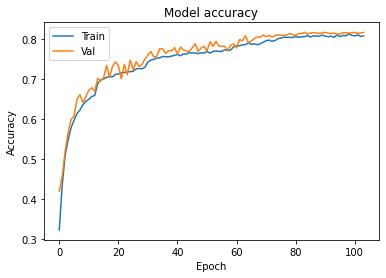

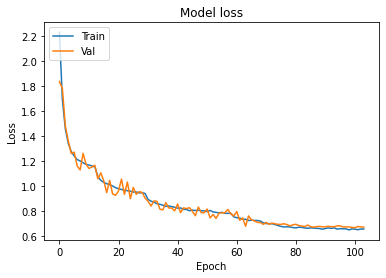

In [11]:
plot_history(history)

## Evaluate the model


In [12]:
_, train_acc = model.evaluate(x_train, y_train, verbose=1)
_, val_acc = model.evaluate(x_val, y_val, verbose=1)

_, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Train: %.3f, val: %.3f,Test: %.3f' % (train_acc,val_acc, test_acc))

313/313 [==============================] - 12s 39ms/step - loss: 0.6983 - accuracy: 0.8064
Train: 0.843, val: 0.817,Test: 0.806
